# **Algorithm of Data Mining - 2024**


##### Group D - Gabriel Pinos, Elena di Grigoli, Darkhan Maksutov, Arman Salahshour
<arman_salahshour@ieee.org>
<maksutov.2113209@studenti.uniroma1.it>
<elenadigrigoli@gmail.com>


---

## **#2 Homework ADM** 


In [ ]:
pip install pandas matplotlib seaborn numpy scipy pywaffle

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from pywaffle import Waffle

In [2]:
# Load the CSV file 
df = pd.read_csv('steam_reviews.csv').drop('Unnamed: 0', axis=1)

# View the first few rows of the dataset
df.head()


# Research questions (RQs)

1. [**RQ1**]  Before diving deep into the dataset provided, it's crucial to understand its structure and main features. Data scientists usually take the first step of performing an Exploratory Data Analysis (EDA). What can you say about our dataset? Please perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.

# **Description of the Dataset**
The Steam Reviews 2021 dataset contains users reviews of different games available on the Steam platform. The review includes some details such as the language of the review, timestamps of when the review was created, and also informations about the reviewers playtime and number of games owned.

This dataset provides insights about user's behavior and about popularity, and feedback accross a wide range of games.

### **Dataset Information**

---

The dataset we are analyzing contains a total of 21,747,371 rows, each representing a review made by a user, and has 23 columns. The first column only holds the row index.

```python
print(df.shape)
(21747371, 23)
```

Upon analyzing the specific columns, we have the following (excluding the first index column):

1. `app_id`: A categorical variable containing the IDs of all reviewed apps, with a total of `315` distinct IDs.
```python
print(df['app_id'].nunique())
```
2. `app_name`: A qualitative variable containing the name of each reviewed app, with `315` distinct names (corresponding to **app_id**).
3. `review_id`: A categorical variable with the unique ID of each review.
4. `language`: A qualitative variable containing the language used in the review, with `28` distinct languages.
```python
print(df['language'].nunique())
```
5. `review`: A qualitative variable containing a short review text written by the user.
6. `timestamp_created`: A discrete numerical variable showing the timestamp when the review was created and published.
7. `timestamp_updated`: A discrete numerical variable (int) showing the timestamp when the review was last updated (if not updated, it is the same as **timestamp_created**).
8. `recommended`: A binary variable (**True/False**) indicating whether the user recommends the game.
9. `votes_helpful`: A discrete numerical variable (int) indicating the number of users that found the review helpful.
10. `votes_funny`:  A discrete numerical variable (int) indicating the number of usersthat found the review funny.
11. `weighted_vote_score`: A continue numerical variable (float) based on **votes_helpful**, giving a weighted score to the review; since **votes_helpful** is binary, this variable often holds a value of zero.
12. `comment_count`: A discrete numerical variable (int) indicating the number of comments on the review.
13. `steam_purchase`: A binary variable (**0/1**) indicating whether the user purchased the game on Steam.
14. `received_for_free`: A binary variable (**0/1**) indicating if the user received the game for free.
15. `written_during_early_access`: A binary variable (**0/1**) indicating if the review was written during the game’s early access period (before its official release).
16. `author.steamid`: A categorical variable with the Steam ID of the review’s author.
17. `author.num_games_owned`: A discrete numeric variable representing the number of games owned by the author on Steam (likely includes free games).
18. `author.num_reviews`: A numeric discrete variable representing the number of reviews written by the author.
19. `author.playtime_forever`: A continue numeric variable (float) representing the total playtime (in minutes) across all games owned by the author.
20. `author.playtime_last_two_weeks`: A continue numeric variable (float) representing the author’s playtime in the two weeks before the review was written, in minutes.
21. `author.playtime_at_review`: A continue numeric variable (float) representing the author’s total playtime at the time of the review in minutes.
22. `author.last_played`: A continue numeric variable (float) representing the time of the author's last played session.

In total, we have four boolean variables, five floats, eleven discrete numeric variables, and three qualitative variables.





In [ ]:
#Visualize the first rows to understand data structure
print(df.head())

In [ ]:
#Dataset characteristic

#Shape of the Dataset
df.shape
#Shows all column names and their data types
df.info()
#Description of the variables
df.describe()
#Count the null values
df.isnull().sum()

### **Pre-Processing**

We conduct a set of operations on the data to prepare it for analysis, such as removing outliers, handling null values, scaling, and transformations.

We start by transforming time-related variables: `timestamp_created`, `timestamp_updated`, and `author.last_played`. These are currently in Unix timestamp format, representing the number of seconds since January 1, 1970 (UTC). To convert them to a readable date format, we use the `pd.to_datetime` function from the pandas library.

```python
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s')
```

This conversion results in a `datetime64[ns]` format, providing a timestamp as `yyyy-mm-dd hh:mm:ss` in UTC.

Next, we handle null values. Several columns contain nulls, with the following counts: 33,748 nulls in `review`, 2 nulls each in `author.playtime_forever`, `author.playtime_last_two_weeks`, and `author.last_played`, and 25,682 nulls in `author.playtime_at_review`.

```python
print(df.isnull().sum())

Unnamed: 0                           0
app_id                               0
app_name                             0
review_id                            0
language                             0
review                           33748
timestamp_created                    0
timestamp_updated                    0
recommended                          0
votes_helpful                        0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
author.steamid                       0
author.num_games_owned               0
author.num_reviews                   0
author.playtime_forever              2
author.playtime_last_two_weeks       2
author.playtime_at_review        25682
author.last_played                   2
```

For variables with only 2 nulls, we drop the corresponding rows (as these nulls occur in the same rows).

For `review` nulls, we opted to leave the cells empty, excluding them from calculations. For `author.playtime_at_review`, we will replace nulls with the column mean (as this is a float column, this operation helps preserve data quality) or alternatively use values from `author.playtime_forever`.

```python
df = df.dropna(subset=['author.playtime_forever', 'author.playtime_last_two_weeks', 'author.last_played'])
mean_playtime_at_review = df['author.playtime_at_review'].mean()
df['author.playtime_at_review'].fillna(mean_playtime_at_review, inplace=True)
```

Next, we calculate summary statistics for relevant variables (those for which min, max, and mean make sense) to identify any unusual values: `comment_count`, `author.num_games_owned`, `author.num_reviews`, `author.playtime_forever`, `author.playtime_last_two_weeks`, `votes_helpful`, `votes_funny`, and `weighted_vote_score`.

```python
stats = df[['comment_count', 'author.num_games_owned', 'author.num_reviews',
                    'author.playtime_forever', 'author.playtime_last_two_weeks',
                    'votes_helpful', 'votes_funny','weighted_vote_score']].agg(['min', 'max', 'mean'])
```

Upon analyzing the data, we detected outliers (extremely atypical values) in the variables `author.num_games_owned`, `author.num_reviews`, `votes_helpful`, and `votes_funny`. Specifically, there are 2 outliers in both `author.num_reviews` and `votes_helpful`, 5 in `author.num_games_owned`, and 642 in `votes_funny`.

For `author.num_games_owned`, we replaced the outlier values with the column mean (excluding these outliers). For the remaining variables with outliers, we removed the corresponding rows.

```python
df = df[
    (df['author.num_games_owned'] <= 50000) &
    (df['author.num_reviews'] <= 50000) &
    (df['votes_helpful'] <= 50000)
]

mean_votes_funny = df.loc[df['votes_funny'] <= 50000, 'votes_funny'].mean()
df.loc[df['votes_funny'] > 50000, 'votes_funny'] = mean_votes_funny
```

In [ ]:
#Converte the timestamp columns from integers to seconds
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s')

In [ ]:
#Manage the Nan values
df = df.dropna(subset=['author.playtime_forever', 'author.playtime_last_two_weeks', 'author.last_played'])
mean_playtime_at_review = df['author.playtime_at_review'].mean()
df['author.playtime_at_review'].fillna(mean_playtime_at_review, inplace=True)

In [ ]:
stats = df[['comment_count', 'author.num_games_owned', 'author.num_reviews',
                    'author.playtime_forever', 'author.playtime_last_two_weeks',
                    'votes_helpful', 'votes_funny','weighted_vote_score']].agg(['min', 'max', 'mean'])

In [ ]:
#Manage the outliers
df = df[
    (df['author.num_games_owned'] <= 50000) &
    (df['author.num_reviews'] <= 50000) &
    (df['votes_helpful'] <= 50000)
]

mean_votes_funny = df.loc[df['votes_funny'] <= 50000, 'votes_funny'].mean()
df.loc[df['votes_funny'] > 50000, 'votes_funny'] = mean_votes_funny

In [ ]:
#Visualize now the first rows to understand the new data structure
print(df.head())

### **Correlation Map**

To visualize the correlation between variables, we created the **Heatmap of Correlations Between Numerical Variables**.

This table displays the correlation coefficient $ r$, which quantifies the linear relationship between two variables. \\
Values close to 1 or -1 indicate a strong relationship between the variables.

In [ ]:
# Select only numerical columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculate the Spearman correlation matrix
correlation_matrix = df_numeric.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Spearman Correlations Between Numerical Variables')
plt.show()

In [ ]:
#Find all unique language values from the 'language' column
Languages = df['language'].unique()

# Print the list of all languages
print(f"List of all Languages: {Languages}")

# Print the number of unique languages
print(f"\nNumber of languages: {len(Languages)}")

# Get the top 9 most frequent languages
top_9_languages = df.language.value_counts().nlargest(9)

# Sum all remaining languages and call them as "Other"
other_languages = df.language.value_counts().iloc[9:].sum()

# Combine the top 9 languages and the "Other" category into one Series
language_counts = pd.concat([top_9_languages, pd.Series({"Other": other_languages})])

explode = [0.1] + [0] * (len(language_counts) - 1)

# Plot the pie chart
ax = language_counts.plot.pie(
    figsize=(10, 10),
    labels=None,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode
)

ax.set_ylabel('')

#Add the legend
plt.legend(
    labels=language_counts.index,
    title="Languages",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.show()
#The largest portion of the chart (39.2%) is for English, followed by Russian (18.6%) and Schinese (12.6%).
#The “Other” category, groups less frequent languages (7.5%).
#English is the primary language for reviews.

In [ ]:
# Analysis of the relationship betweem number of games owned vs number of reviews written
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='author.num_games_owned', y='author.num_reviews', alpha=0.5, color= 'green')
plt.title('Number of Games Owned vs Number of Reviews Written')
plt.xlabel('Number of Games Owned')
plt.ylabel('Number of Reviews Written')
plt.show()
# The plot shows that users with more games tend to write more reviews, although some exceptions.
# The heatmap also reflects a moderate positive correlation between these two variables.

In [ ]:
# Group by user and game, count duplicate reviews
duplicate_reviews = df.groupby(['author.steamid', 'app_id']).size().reset_index(name='count')

# Filter only the pairs with more than one review
duplicate_reviews = duplicate_reviews[duplicate_reviews['count'] > 1]

# Count the number of users who left more than one review
num_multiple_reviews = duplicate_reviews['author.steamid'].nunique()
print(f"Number of users who left more than one review: {num_multiple_reviews}")

# Merge to obtain the original duplicate review data
duplicate_reviews_data = df.merge(duplicate_reviews[['author.steamid', 'app_id']], on=['author.steamid', 'app_id'])

# Check for changes in the 'recommended' column
changed_recommendations = duplicate_reviews_data.groupby(['author.steamid', 'app_id'])['recommended'].nunique().reset_index()
changed_recommendations = changed_recommendations[changed_recommendations['recommended'] > 1]

# Count the number of users who changed their minds
num_changed = changed_recommendations.shape[0]
print(f"Number of users who changed their minds: {num_changed}")

# Get the original rows corresponding to those who changed their minds
changed_users = duplicate_reviews_data[duplicate_reviews_data.set_index(['author.steamid', 'app_id']).index.isin(changed_recommendations.set_index(['author.steamid', 'app_id']).index)]

# Select only the desired columns
result = changed_users[['author.steamid', 'app_id', 'recommended']]

# Print the corresponding rows
print("Rows corresponding to users who changed their minds:")
print(result)

In [ ]:
import matplotlib.cm as cm

# Group 'author.num_games_owned' into categories
bins = [0, 50, 100, 200, 500, df['author.num_games_owned'].max()]
labels = ['0-50', '51-100', '101-200', '201-500', '500+']
df['games_owned_category'] = pd.cut(df['author.num_games_owned'], bins=bins, labels=labels)

# Choose a color palette (viridis with 5 colors)
palette = cm.get_cmap('viridis', 5)
colors = [palette(i) for i in range(5)]

# Plot the bar chart with colors applied
plt.figure(figsize=(10, 6))
df['games_owned_category'].value_counts().sort_index().plot(kind='bar', color=colors,edgecolor='black')
plt.title('Distribution of Number of Games Owned',fontsize=16, fontweight='bold')
plt.xlabel('Games Owned Category', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=0)
plt.show()

#0-50 Games: This category has the highest number of users, indicating that most Steam users own a relatively small number of games. The bar for this category is significantly taller compared to the others.
#51-100 Games: The number of users owning 51-100 games is noticeably lower than the first group but still forms a considerable portion of the user base.
#101-200 Games: There is a slight decline in the number of users as we move to this range.
#201-500 Games: continues the declining trend.
#500+ Games: The number of users owning 500 or more games is the smallest, suggesting that only a minority of users own such an extensive game library.

In [ ]:
data = df['steam_purchase'].value_counts()

total = data.sum()
percent_data = (data / total * 100).round(2)

colors = ["green", "red"]

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=percent_data,
    colors=colors,
    icons=['dollar-sign' if val else 'gift' for val in percent_data.index],  # dollar-sign
    icon_size=30,
    icon_legend=True,
    labels=[f"{'Steam Purchase' if val else 'No Purchase'}: {count}%" for val, count in zip(percent_data.index, percent_data)],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1), 'prop': {'size': 14}},
    title={'label': 'Proportion of Steam Purchases', 'loc': 'center', 'fontsize': 16, 'fontweight': 'bold'},
    figsize=(12, 7)
)

plt.show()


#The chart shows that 83.5% of the games reviewed were purchased on Steam. This indicates that the vast majority of players
#are buying their games directly through the Steam platform.
#The remaining 16.5% of games were not purchased on Steam, which could include games received as gifts, purchased on
#other platforms, or obtained through free offers

---

We conducted this analysis to verify whether there was a spike in the average number of hours played during the COVID period, specifically from the beginning of 2020 to 2021, due to users spending more time at home and possibly playing games. However, the results are the opposite of what we expected, as we observed a nearly drastic decline starting in 2020.

The causes of this phenomenon may be varied but it is nevertheless interesting to observe this trend opposite to what we expected.

2. [**RQ2**] *Let's explore the dataset by analyzing the distribution of reviews across different applications.*
   - Identify which applications have the highest and lowest number of reviews.
   - Plot the number of reviews for each application in descending order. What insights can you draw from the plot?
   - For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.
   - Which applications have the most and the least user recommendations? Summarize your findings.
   - Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

#### Identify which applications have the highest and lowest number of reviews.

In [ ]:
app_review_numbers = df['app_name'].value_counts() # count the occurence for all the application

most_review_app = app_review_numbers.idxmax()
most_review_count = app_review_numbers.max()

least_review_app = app_review_numbers.idxmin()
least_review_count = app_review_numbers.min()

print(f"Most reviewed game: {most_review_app} ({most_review_count} reviews)")
print(f"Least reviewed game: {least_review_app} ({least_review_count} reviews)")

#### Plot the number of reviews for each application in descending order. What insights can you draw from the plot?

In [ ]:
import matplotlib.ticker as mtick
import textwrap
import plotly.express as px

# Sort the review counts for all applications
app_review_sorted = app_review_numbers.sort_values(ascending=False)

# Convert `app_review_sorted` to a DataFrame to make it compatible with Plotly
app_review_sorted_df = app_review_sorted.reset_index()
app_review_sorted_df.columns = ['Application', 'Number of Reviews']

# Create the bar chart with Plotly
fig = px.bar(
    app_review_sorted_df,
    x='Application',
    y='Number of Reviews',
    title='Number of Reviews per Application (All Data)',
    labels={'Application': 'Applications', 'Number of Reviews': 'Number of Reviews'},
    color='Number of Reviews',  # Color based on the number of reviews
    color_continuous_scale='viridis'  # Use the 'viridis' color palette
)

# Configure layout for vertical scrolling and formatting
fig.update_layout(
    height=900,  # Adjust the height of the chart
    width=1800,  # Adjust the width of the chart
    xaxis={'categoryorder': 'total descending'},  # Sort applications by descending review count
    showlegend=False,
)

# Format the y-axis to show values in millions
fig.update_yaxes(tickformat=".1fM", title_font=dict(size=16))  # Format to show in millions, e.g., 1.0M

# Remove x-axis labels
fig.update_xaxes(showticklabels=False)

# Show the Plotly chart
fig.show()

# Create subplots for the top and bottom 10 applications
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Set the color palette for seaborn
viridis = sns.color_palette("viridis", 10)

# Plot the top 10 applications
wrapped_labels_top = [textwrap.fill(label, width=15) for label in app_review_sorted.index[:10]]
sns.barplot(ax=axes[0], y=app_review_sorted.values[:10], x=wrapped_labels_top, palette=viridis, edgecolor='black')
axes[0].set_title('Top 10 Applications by Number of Reviews', fontsize=20, fontweight='bold')
axes[0].set_xlabel('Application Name', fontsize=14)
axes[0].set_ylabel('Number of Reviews (in millions)', fontsize=14)
axes[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}M'))

# Plot the bottom 10 applications
wrapped_labels_bottom = [textwrap.fill(label, width=15) for label in app_review_sorted.index[-10:]]
sns.barplot(ax=axes[1], y=app_review_sorted.values[-10:], x=wrapped_labels_bottom, palette=viridis, edgecolor='black')
axes[1].set_title('Bottom 10 Applications by Number of Reviews', fontsize=20, fontweight='bold')
axes[1].set_xlabel('Application Name', fontsize=14)
axes[1].set_ylabel('Number of Reviews', fontsize=14)

# Display the matplotlib plots
plt.tight_layout()
plt.show()

In this graph we can observ a very popular phenomenon which is very common in digital marketplace sush as Steam. This theory is called **"The Long Tail"** and it explains that in online markets, the aggregation of numerous niche products, can collectively contribute significantly to the platform's overall activity.
This pattern is clearly illustrated in the graph: a small number of games, such as Garry's Mod and The Witcher 3: Wild Hunt, represent the majority of the reviews, representing the "head" of the distribution.

As we move along the x-axis, we can see the long tail represented by less popular games which receive fewer reviews.
However, those games in the long tail, that have a low individual popularity, even if individually might seem insignificant, collectively, they represent a large and valuable portion of the review activity on Steam.

The graph reflects that thanks to the long tail effect, digital platforms can capture value not only from the most popular games, but also from the aggregations of niche products, that can be as impactful as those games with a big audience.

*Anderson, C. (2006). The Long Tail: Why the Future of Business is Selling Less of More. Hyperion.*

#### For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.

In [ ]:
top_5 = app_review_sorted.head(5).index #Variable of the top 5 review
top_5 = df[df['app_name'].isin(top_5)]

purchase_counts = top_5.groupby(['app_name', 'steam_purchase']).size().unstack(fill_value=0) # Variable for the number pf purchase
purchase_percentages = round(purchase_counts.div(purchase_counts.sum(axis=1), axis=0) * 100 , 2)

print(purchase_percentages)

# Plot the puchasing percentages for the top 5 application
fig, axes = plt.subplots(2, 3, figsize=(13, 9))

axes = axes.flatten()
for i, app in enumerate(purchase_percentages.index):
    app_data = purchase_percentages.loc[app]
    wedges, texts, autotexts = axes[i].pie(app_data, labels=None, autopct='%1.1f%%',
                                           explode=[0.05, 0], colors=['#800080', '#fac205'],
                                           shadow=True, startangle=90)
    axes[i].set_title(f'{app}',fontweight="bold")
axes[5].axis('off')
fig.legend(wedges, ['Purchased', 'Received for Free'], loc=7)
plt.tight_layout()
plt.show()


# Obviously the majority of users purchased the game ,around 80%,
# only around 20% at most received it as a gift

#### Which applications have the most and the least user recommendations? Summarize your findings.

In [ ]:
#Print the application with the most and least reccomendation
number_recommendation = df.groupby('app_name')['recommended'].sum()

most_recommended_app = number_recommendation.idxmax()
most_recommended_count = number_recommendation.max()

least_recommended_app = number_recommendation.idxmin()
least_recommended_count = number_recommendation.min()

print(f"Most recommended app: {most_recommended_app} ({most_recommended_count} recommendations)")
print(f"Least recommended app: {least_recommended_app} ({least_recommended_count} recommendations)")

#Print the most and least percentage of reccomendation on the total review for application
perc_recommendation = (number_recommendation/app_review_numbers)*100

most_recommended_app_perc = perc_recommendation.idxmax()
most_recommended_perc = round(perc_recommendation.max(),2)

least_recommended_app_perc = perc_recommendation.idxmin()
least_recommended_perc = round(perc_recommendation.min(),2)

print(f"Most percentuage of recommendation on the total review app: {most_recommended_app_perc} ({most_recommended_perc} %)")
print(f"Least percentuage of recommendation on the total review app: {least_recommended_app_perc} ({least_recommended_perc} %)")

#  The number of recommendations is strongly linked to the number of reviews,
# the most interesting data is the percentage of the number of recommendations, normalized with the number of reviews.

#### Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

In [ ]:
#Create the review Score column using the reccomendation on the total number of review
df['review_score'] = df['app_name'].map(lambda x: (number_recommendation.get(x, 0) / app_review_numbers.get(x, 1)) * 100)
print(df[['app_name', 'recommended', 'review_score']].head())

In [ ]:
from scipy import stats

# Assuming df is already defined
# Remove rows with missing values
df_cleaned = df[['recommended', 'review_score']].dropna()

# Check if we have enough data points
if len(df_cleaned) < 2:
    print("Not enough data points to calculate correlation.")
else:
    # Pearson Correlation
    correlation, p_value = stats.pearsonr(df_cleaned['recommended'], df_cleaned['review_score'])

    print(f"Pearson Correlation Coefficient: {correlation}")
    print(f"P-value: {p_value}")

    alpha = 0.05  # More common threshold for significance
    if p_value < alpha:
        print("We refuse the null hypothesis: there is a strong correlation between recommended and review_score.")
    else:
        print("We can't refuse the null hypothesis: there isn't a strong correlation between recommended and review_score.")

    #############################################################################################################################

# Spearman Correlation
spearman_corr, spearman_p_value = stats.spearmanr(df_cleaned['recommended'], df_cleaned['review_score'])

print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"Spearman P-value: {spearman_p_value}")

if spearman_p_value < alpha:
    print("We refuse the null hypothesis: there is a strong correlation between recommended and review_score (Spearman).")
else:
    print("We can't refuse the null hypothesis: there isn't a strong correlation between recommended and review_score (Spearman).")



**What is Pearson Correlation?**

The **Pearson correlation** (or Pearson correlation coefficient) is a statistical measure that quantifies the **strength** and **direction** of the linear relationship between two variables and so it is one of the most commonly used tools in statistics to understand if there is a relationship between two variables and, if so, how strong that relationship is. The Pearson Correlation Formula is :
$$
r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2} \sum{(y_i - \bar{y})^2}}}
$$

Where:
- $x_i$ and $y_i$ are the values of the two variables,
- $ \bar{x} $ and $ \bar{y} $ are the means of the values of the two variables,
- $ \sum $ denotes the sum over all data points.

The value of $r$ ranges between **-1** and **1**:
- **$ r = 1 $**: A perfectly positive linear relationship (when one variable increases, the other increases proportionally).
- **$ r = -1 $**: A perfectly negative linear relationship (when one variable increases, the other decreases proportionally).
- **$ r = 0 $**: No linear relationship between the two variables.


**What is the P-value**


The **p-value** associated with Pearson's correlation helps determine whether the correlation coefficient $r$ is **statistically significant** :

is the probability of obtaining a result at least as the one observed, assuming the **null hypothesis (H₀)** is true. In the context of Pearson's correlation, the null hypothesis states that **there is no correlation** between the two variables (i.e., $ r = 0 $ ).

- If the **p-value is low** (below a significance level $\alpha = 0.5$), we reject the null hypothesis and conclude that there is a significant correlation between the two variables.
- If the **p-value is high** (greater than $\alpha=0.5$), we cannot reject the null hypothesis, meaning we don't have enough evidence to say there is a significant correlation.



####   *Important*
To use the Pearson correlation correctly, the following assumptions must be met:
1. **Linear relationship**: The two variables must have a linear relationship. If the relationship is not linear, Pearson's correlation may not be appropriate.
2. **Normal distribution**: The variables should be approximately normally distributed.
3. **Absence of outliers**: Outliers can strongly affect the value of $r$, so it's important to check for extreme values.


**Spearman's Rank Correlation**

Due to the assumptions involved, Pearson’s correlation may not be the best choice here. Instead, we’ve chosen to use Spearman's Rank Correlation because it has the following advantages:

   - **No Assumption of Normality**: Spearman's is ideal for data that does not follow a normal distribution, which is common in real-world datasets.
   - **Detects Monotonic Relationships**: Unlike Pearson’s correlation, which only detects linear relationships, Spearman’s can capture monotonic trends even if they’re non-linear.
   - **Robust to Outliers**: Because Spearman’s ranks data, extreme values (outliers) don’t have as large an impact as they do in parametric methods.
   - **Suitable for Ordinal Data**: Works well with ordinal data, where the values represent rankings rather than exact quantities.

The formula for Spearman’s rank correlation is:
$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$
where ($ d_i $) is the difference between the ranks of each pair and ( $n$ ) is the number of pairs.

The result ranges between -1 and +1, similar to Pearson’s coefficient, but with a slightly different interpretation:
   - **+1**: A perfect positive monotonic relationship (as one variable increases, the other also increases).
   - **0**: No monotonic relationship.
   - **-1**: A perfect negative monotonic relationship (as one variable increases, the other decreases).
---

The **Pearson correlation coefficient** was found to be **0.3975**. This value indicates a moderate positive correlation between the `recommended` status and the `review_score` that suggests that as the review score increases, the likelihood of a recommendation also tends to increase.
The  p-value is **0.0**, which is well below significance level (e.g., 0.05), so we reject the null hypothesis, concluding that there is a **statistically significant correlation between the two variables**.

The **Spearman correlation coefficient** was calculated as **0.3360**. This also indicates a moderate positive correlation and then confirms the findings of the Pearson correlation.
Similar to the Pearson results, the Spearman p-value is also **0.0**, this suggests that the correlation is statistically significant, reinforcing the relationship observed with the Pearson method.

The significance of the p-values in both tests strongly suggests that higher review scores are associated with a greater likelihood of a recommendation.

**The obtained values align with our expectations. By definition, the review score is calculated as the number of recommendations divided by the total number of reviews for each game. This inherently implies a correlation with the number of recommendations. However, it is important to note that the correlation coefficients are not excessively high, indicating that the relationship is not perfect.**

3. [**RQ3**] *Understanding when users are most active in submitting reviews can help identify peak engagement periods.*
   - Plot the number of reviews submitted each month and describe any trends.
   - Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.
   - Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.
   - What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.
   - Create a function that accepts a list of time intervals and plots the number of reviews for each interval.
   - Use the function to plot the number of reviews for the following time intervals:

| Initial Time | Final Time |
|--------------|------------|
| 00:00:00     | 02:59:59   |
| 03:00:00     | 05:59:59   |
| 06:00:00     | 10:59:59   |
| 11:00:00     | 13:59:59   |
| 14:00:00     | 16:59:59   |
| 17:00:00     | 19:59:59   |
| 20:00:00     | 23:59:59   |

   - Summarize your findings from the time interval analysis.

In [ ]:
cols = ['review_id', 'timestamp_created']
df_temp = df[cols]

In [ ]:
# Plot the number of reviews submitted each month and describe any trends


# Select relevant columns for analysis
cols = ['review_id', 'timestamp_created']
df_temp = df[cols].copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning

# Extract month names from the timestamp using .loc
df_temp.loc[:, 'month'] = df_temp['timestamp_created'].dt.month_name()

# Define the order of the months
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Count reviews per month and ensure the order is correct
reviews = df_temp['month'].value_counts().reindex(months)

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(months, reviews, color=sns.color_palette("viridis", len(reviews)), edgecolor='black')  # Use viridis color palette

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Submitted Each Month')

# Add a line connecting the tops of the bars
plt.plot(months, reviews, color='black', marker='o', linestyle='-')

# Rotate x-axis labels for better visibility
plt.xticks()

# Add gridlines for easier reading of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make it neat
plt.tight_layout()

# Show the plot
plt.show()


There are noticeable peaks in **January, November and December**, with November having the highest count of reviews by a significant margin. This suggests that specific times of the year experience surges in review activity, possibly linked to seasonal events or promotions. For instance, November and December coincide with major Steam sales, which likely encourage increased gaming activity and, consequently, more reviews. January also sees a relatively high volume of reviews, potentially due to the holiday season, when people have more free time to play and review games.

In [ ]:
# Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.

from statsmodels.tsa.seasonal import seasonal_decompose

df_temp['year'] = df_temp['timestamp_created'].dt.year
df_temp['month'] = df_temp['timestamp_created'].dt.month

# Group by year and month to get monthly review counts
monthly_counts = df_temp.groupby(['year', 'month']).size().reset_index(name='review_count')

# Convert to a time series format with a Datetime index
monthly_counts['date'] = pd.to_datetime(monthly_counts[['year', 'month']].assign(day=1))
monthly_counts.set_index('date', inplace=True)
monthly_counts = monthly_counts['review_count']


# Using seasonal decomposition to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Monthly Review Counts")
plt.tight_layout()
plt.show()

An upward trend can be observed in review activity, suggesting that Steam's user engagement has been **growing steadily over time**. Notably, there are recurring seasonal patterns with peaks around June and November. These months likely correspond to Steam's **Summer and Winter sales**, where users are more active in purchasing and reviewing games. Additionally, the sharp increase in the trend around 2019–2020 may be associated with the **COVID-19 pandemic**, as more people turned to gaming. The seasonal component reveals that user engagement is highly influenced by recurring annual events. The residuals indicate occasional outliers, potentially due to significant game releases.

In [ ]:
# Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

average_reviews = monthly_counts.groupby(monthly_counts.index.month).mean()

plt.figure(figsize = (12, 6))
plt.plot(average_reviews.index, average_reviews.values)
plt.xlabel('Month')
plt.ylabel('Average Number of Reviews')
plt.title('Average Monthly Review Counts Across All Years')
plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.grid()
plt.show()


print("Average Reviews by Month:")
print(round(average_reviews, 1))

peak_months = average_reviews[average_reviews > average_reviews.mean()]
print("\nPeak Months with Higher Engagement Rates:")
print(round(peak_months, 1))


In [ ]:
# What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.

df_temp['time_of_day'] = df_temp['timestamp_created'].dt.strftime('%H:%M')

reviews_by_time = df_temp.groupby('time_of_day').size().reset_index(name = 'count')

ind = reviews_by_time['count'].idxmax()
most_common = reviews_by_time.loc[ind, 'time_of_day']
most_count = reviews_by_time.loc[ind, 'count']

print(f'The most common time of day for writing reviews is {most_common} with {most_count} reviews.')

This pattern could imply that review activity **is not strictly limited to evenings**, as might be expected. It may also highlight the importance of considering global user bases, as time zone differences could mean that 14:50 corresponds to **late evening or early morning** in other regions.

In [ ]:
# Create a function that accepts a list of time intervals and plots the number of reviews for each interval.



def plot_by_intervals(df, intervals):
    # Convert the 'timestamp_created' column to a time of day format (HH:MM:SS)
    df['time_of_day'] = df['timestamp_created'].dt.strftime('%H:%M:%S')
    counts = []  # Initialize a list to hold the counts of reviews for each interval

    # Iterate through each time interval
    for start, end in intervals:
        # Count the number of reviews within the current time interval
        count = len(df[(df['time_of_day'] >= start) & (df['time_of_day'] <= end)])
        counts.append(count)  # Append the count to the counts list

    # Create a temporary DataFrame to store the intervals and their corresponding counts
    temp_df = pd.DataFrame({
        'Interval': [f'{i}-{j}' for i, j in intervals],
        'Count': counts
    })

    # Plotting the results using a bar chart
    plt.figure(figsize=(12, 6))
    # Use the viridis palette for the bars, with a black edge
    bars = plt.bar(temp_df['Interval'], temp_df['Count'], color=sns.color_palette("viridis", len(temp_df)), edgecolor='black')
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Reviews')
    plt.title('Number of Reviews by Time Interval')
    plt.xticks(rotation=0)  # Set x-axis labels to be horizontal

    # Adjust x-ticks to add line breaks for better visibility
    plt.xticks(ticks=range(len(temp_df['Interval'])),
               labels=[f'{i}\n{j}' for i, j in intervals],
               rotation=0)

    # Add a line connecting the tops of the bars
    plt.plot(temp_df['Interval'], temp_df['Count'], color='black', marker='o', linestyle='-')

    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for easier reading of values
    plt.tight_layout()  # Automatically adjust subplot parameters for a neat fit
    plt.show()

# Define the time intervals to analyze
time_intervals = [
    ('00:00:00', '02:59:59'),
    ('03:00:00', '05:59:59'),
    ('06:00:00', '10:59:59'),
    ('11:00:00', '13:59:59'),
    ('14:00:00', '16:59:59'),
    ('17:00:00', '19:59:59'),
    ('20:00:00', '23:59:59')
]

# Call the function with the DataFrame containing review data
plot_by_intervals(df_temp, time_intervals)


The time interval analysis shows that user review activity peaks between **06:00-10:59** and **20:00-23:59**, suggesting high engagement during early mornings and late evenings. This pattern likely reflects the influence of global time zones, with certain regions accessing the platform during these times when it aligns with their evenings or relaxed hours. The lowest engagement occurs from **03:00-05:59**, a period that may align with late-night hours for most users.

4. [**RQ4**] *Investigating whether users who spend more time using an application give higher or lower ratings.*
   - Analyze the relationship between the amount of time a user has spent on an application and their review score.
   - Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.
   - Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.
   - Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

In [ ]:
plt.figure(figsize=(12, 6))
plt.hexbin(df['author.playtime_forever'], df['weighted_vote_score'], gridsize=60, cmap='coolwarm')
plt.colorbar(label='Density')
plt.title('Relationship Between Playtime and Review Score (Density)')
plt.xlabel('Total Playtime (minutes)')
plt.ylabel('Weighted Vote Score')
plt.tight_layout()
plt.show()

Index(['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

In [ ]:
sns.set_theme(style="whitegrid")  
# Analyze the relationship between the amount of time a user has spent on an application and their review score.

import matplotlib.ticker as ticker
from scipy.stats import pearsonr

plt.figure(figsize=(12, 6))
plt.scatter(x= df['author.playtime_forever'], y = df['weighted_vote_score'], alpha = 0.5)
plt.title('Relationship Between Playtime and Review Score')
plt.xlabel('Total Playtime (minutes)')
plt.ylabel('Weighted Vote Score')

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Perform Spearman correlation calculation
spearman_corr_matrix = df[['author.playtime_forever', 'weighted_vote_score']].corr(method='spearman')

spearman_corr_matrix

#### Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

The analysis between *author.playtime_forever* and *weighted_vote_score* using Spearman correlation revealed a coefficient of approximately 0.043, indicating a very weak or negligible monotonic relationship. The scatter plot visually supports this, showing a dispersed set of points without a clear pattern between the two variables. Spearman correlation was chosen due to its robustness against outliers and suitability for non-linear and non-normally distributed data, which fits the context of user playtime that can have extreme values. **This implies that regardless of how long users have engaged with the application, their ratings remain relatively consistent.**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


df['weighted_vote_score'] = df['weighted_vote_score'] * 100
df['author.playtime_at_review'] = df['author.playtime_at_review'] / 3600
# Define thresholds
low_threshold = 10
high_threshold = 200

# Get the categorical variable 'user_experience' basing on the user's playtime
df['user_experience'] = df['author.playtime_forever'].apply(
    lambda x: 'New player' if 0 < x < low_threshold
    else 'Casual player' if low_threshold <= x < high_threshold
    else 'Veteran'
)
# Check the user_experience distribution
df['user_experience'].value_counts()


# Imposta il tema desiderato
sns.set_theme(style="whitegrid")  # Cambia 'whitegrid' con il tema che preferisci

# Esempio di grafico
plt.figure(figsize=(12, 6))
sns.violinplot(x='user_experience_level', y='weighted_vote_score', data=df, inner='quartile', palette='pastel')
plt.title('Distribution of Review Scores by User Experience Level')
plt.xlabel('User Experience Level')
plt.ylabel('Review Score')
plt.grid(True)
plt.show()



In [ ]:
# Set Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# Categorize playtime and user experience
df['weighted_vote_score'] = df['weighted_vote_score'] * 100
df['author.playtime_at_review'] = df['author.playtime_at_review'] / 3600

# Define thresholds
low_threshold = 10
high_threshold = 200

# Create user experience categories
df['user_experience'] = np.where(
    df['author.num_games_owned'] <= df['author.num_games_owned'].quantile(0.33), 'New',
    np.where(df['author.num_games_owned'] <= df['author.num_games_owned'].quantile(0.67), 'Intermediate', 'Veteran')
)

# Define playtime bins and labels
playtime_thresholds = [0, 1, 5, 10, 20, 50, 100, 200, df['author.playtime_forever'].max()]
playtime_labels = ['0-1h', '1-5h', '5-10h', '10-20h', '20-50h', '50-100h', '100-200h', '200h+']
df['users_playtime'] = pd.cut(df['author.playtime_forever'], bins=playtime_thresholds, labels=playtime_labels)

# Calculate recommendation rate per user experience and playtime category
result = df.groupby(['user_experience', 'users_playtime'], observed=False)['recommended'].mean().reset_index()
result['recommendation_rate'] = result['recommended'] * 100

# Plot with Seaborn for each user experience level
plt.figure(figsize=(14, 7))
sns.lineplot(data=result, x='users_playtime', y='recommendation_rate', hue='user_experience', marker='o',linewidth=3.5)

# Titles and labels
plt.title('Comparison of Recommendation Rates: New vs. Intermediate vs. Veteran Users')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=75)
plt.legend(title='User Experience Level')
plt.tight_layout()
plt.show()

This graph illustrates the variation in recommendation rates across different playtime categories for New Users, Intermediate, and Veteran users. The x-axis represents distinct playtime ranges in hours, and the y-axis shows the recommendation rate as a percentage.
1.	0-1h : Veteran users start with a higher recommendation rate compared to New and Intermediate users, suggesting that experienced users may have more initial optimism or familiarity with games.
2.	1-5h: All three groups exhibit a steep decline in recommendation rates as playtime increases to 1-5 hours. 
3.	From 10 hours onward, recommendation rates begin to increase for all user groups, with a marked increase as playtime extends to over 200 hours. This trend implies that as players invest more time, they are likely to have a more favorable view of the game.



New Users: 

Maintain consistently moderate recommendation rates but show less fluctuation over time.
Intermediate Users:

 Experience a steadier rate across most playtime categories, suggesting a balanced perception.
Veteran Users:

 Show more variation, initially high rates that dip significantly but then recover as playtime increases.

In [ ]:
from scipy.stats import f_oneway

# Perform ANOVA to determine if there is a statistically significant difference between groups

groups = [group['weighted_vote_score'].dropna() for name, group in df.groupby('user_experience_level')]

# Perform ANOVA test
anova_statistic, anova_p_value = f_oneway(*groups)

print("ANOVA Test Results:")
print(f"Test Statistic: {anova_statistic:.2f}")
print(f"p-value: {anova_p_value:.2e}")

if anova_p_value < 0.05:
    print("\nThe ANOVA test indicates a statistically significant difference in the distribution of review scores between user experience levels.")
else:
    print("\nThe ANOVA test does not indicate a statistically significant difference in the distribution of review scores between user experience levels.")

##### Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

The statistical analysis using ANOVA confirmed significant differences in review score distributions across new, intermediate, and veteran users. This suggests that user experience levels influence rating behavior. Veteran users, who have spent considerable time on the app, might give higher ratings due to loyalty, familiarity, or an investment bias, where users who have invested significant time tend to rate more favorably due to their sustained commitment. Conversely, intermediate users might exhibit lower ratings as they navigate the app more critically during a transition phase where novelty wears off but mastery has not been achieved. New users, on the other hand, may rate based on initial expectations, leading to either very positive or neutral scores. Factors such as the quality of updates, community influence, perceived value, and user satisfaction over time could all contribute to these observed trends. Additionally, individual motivations, specific use cases, and expectations tied to personal goals or app functionality may explain why some users rate higher or lower based on their usage duration.

5. [**RQ5**] *It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.*
   - Determine the ten reviewers with the highest number of reviews in the dataset.
   - What is the percentage of each language used by these top 10 reviewers when submitting a review?
   - Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.
   - Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

#### Determine the ten reviewers with the highest number of reviews in the dataset.

In [ ]:
# Group by reviewer and get the top 10 reviewers
top_reviewers = df.groupby('author.steamid').size().nlargest(10)
print(f"The 10 reviewers with the most reviews are:\n{top_reviewers}")

#### What is the percentage of each language used by these top 10 reviewers when submitting a review?

In [ ]:
# Filter the original DataFrame to get the data for the top 10 reviewers
top_10_reviewers = df[df['author.steamid'].isin(top_reviewers.index)]

# Count the languages used by the top 10 reviewers
language_counts = top_10_reviewers['language'].value_counts()
total_counts = language_counts.sum()
language_percentages = language_counts / total_counts * 100

# Print the language percentages
print("Language Usage Percentages among Top 10 Reviewers:")
for lang, percent in zip(language_counts.index, language_percentages):
    print(f"{lang}: {percent:.1f}%")

# Create a dictionary with names and percentages only
language_dict = {f"{lang} ({percent:.1f}%)": percent
                 for lang, percent in zip(language_counts.index, language_percentages)}

# Plot the waffle chart with specified number of columns, legend, and larger figure size
fig = plt.figure(
    FigureClass=Waffle,
    rows=20,
    columns=10,  # Specify the number of columns
    values=language_dict,  # Use dictionary with only percentages
    colors=['mediumorchid', 'lime', 'orange'],  # Purple, Yellow, Orange
    figsize=(12, 8),  # Set figure size to 12x8 inches
    title={'label': 'Language Usage Among Top 10 Reviewers', 'loc': 'center', 'fontsize': 16, 'fontweight': 'bold'},
    legend={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'fontsize': 10,
        'title': 'Languages',
        'title_fontsize': 12
    },
    block_aspect_ratio=1,  # Make each block square
)
for patch in fig.axes[0].patches:
    patch.set_edgecolor('black')  # Set edge color to black
    patch.set_linewidth(0.5)

plt.show()


#Language Usage Percentages among Top 10 Reviewers:
# english: 53.9%
# russian: 28.1%
# schinese: 17.9%


#### Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.

In [ ]:
# Calculate the mean of helpful votes for each of the top 10 reviewers
avg_votes_helpful = top_10_reviewers.groupby('author.steamid')['votes_helpful'].mean()
print("Mean of helpful votes from the top 10 reviewers:")
print(avg_votes_helpful)

# Barplot
plt.figure(figsize=(10,6))  # Set the figure size for the bar plot
x_labels = range(1, 11)  # Define x-axis labels for reviewers from 1 to 10
colors = plt.get_cmap("inferno")(np.linspace(0, 1, len(avg_votes_helpful)))  # Generate a color gradient for the bars

# Plot the mean of helpful votes as a bar chart
avg_votes_helpful.plot(kind='bar', color=colors, edgecolor='black')  # Plot with colored bars and black edges
plt.xticks(ticks=range(len(avg_votes_helpful)), labels=x_labels)  # Set x-axis ticks and labels for reviewers

# Set plot title and labels
plt.title('Mean of Helpful Votes from the Top 10 Reviewers', fontweight='bold', fontsize=20)
plt.xlabel('Reviewer Index (1 to 10)', fontsize=14)
plt.ylabel('Mean of Helpful Votes', fontsize=14)

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()  # Display the plot


# Many of them just spam reviews

####   Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

In [ ]:
import plotly.express as px

# Group and sort the count of reviews per app
reviews_per_app = top_10_reviewers.groupby('app_name').size().sort_values(ascending=False)

# Convert `reviews_per_app` to a DataFrame to make it compatible with Plotly
reviews_per_app_df = reviews_per_app.reset_index()
reviews_per_app_df.columns = ['Game', 'Number of Reviews']

# Create the vertical bar chart with Plotly
fig = px.bar(
    reviews_per_app_df,
    x='Game',
    y='Number of Reviews',
    title='Distribution of the Number of Reviews for the Top 10 Reviewers',
    labels={'Game': 'Game', 'Number of Reviews': 'Number of Reviews'},
    color='Number of Reviews',  # Color based on the number of reviews
    color_continuous_scale='YlGnBu'
)

# Configure layout to enable vertical scrolling
fig.update_layout(
    height=1000,  # Total height of the chart (increased from 800 to 1000)
    width=3000,   # Total width of the chart (you can set the desired value)
    xaxis={'categoryorder': 'total descending'},  # Descending order
    showlegend=False,
)

# Enable scrolling on the x-axis if there are many games
fig.update_xaxes(tickangle=-45, automargin=True, dtick=1, tickvals=[], ticktext=[])

# Show the chart
fig.show()


6. [**RQ6**] *Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers*
    - Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?
    - Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?

In [4]:
#English or Spanish
# First solution for the first challenge of RQ6:

df_updated_english = df[(df.language=='english') & (df.timestamp_created < df.timestamp_updated)]
df_updated_spanish = df[(df.language=='spanish') & (df.timestamp_created < df.timestamp_updated)]

prob_english_updated = len(df_updated_english) / len(df[(df.language=='english')])
prob_num_spanish_updated = len(df_updated_spanish) / len(df[(df.language=='spanish')])

prob_english_updated = round(prob_english_updated, 2)
prob_num_spanish_updated = round(prob_num_spanish_updated, 2)

if prob_english_updated > prob_num_spanish_updated:
    print(f'Review in English are more likely to be edited or updated ({prob_english_updated} English, {prob_num_spanish_updated} Spanish)')
elif prob_num_spanish_updated > prob_english_updated:
    print(f'Review in Spanish are more likely to be edited or updated ({prob_num_spanish_updated} Spanish, {prob_english_updated} English)')
else:
    print(f'Reviews in both English and Spanish are equally likely to be edited or updated ({prob_english_updated} English, {prob_num_spanish_updated} Spanish)')
    

# Second solution for the first challenge of RQ6:
df['edited'] = df['timestamp_updated'] > df['timestamp_created']
edited_proportion = df.groupby('language')['edited'].mean()
edited_proportion[(edited_proportion.index=='english') | (edited_proportion.index=='spanish')]

Review in English are more likely to be edited or updated (0.12 English, 0.1 Spanish)


language
english    0.118948
spanish    0.099351
Name: edited, dtype: float64

In [5]:
# Solution for the second challenge of RQ6


avg_games_owned = df.groupby('language')['author.num_games_owned'].mean()
avg_reviews_written = df.groupby('language')['author.num_reviews'].mean()

med_games_owned = df.groupby('language')['author.num_games_owned'].median()
med_reviews_written = df.groupby('language')['author.num_reviews'].median()

avg_games_owned_en_es = avg_games_owned.loc[['english', 'spanish']]
avg_reviews_written_en_es = avg_reviews_written.loc[['english', 'spanish']]

med_games_owned_en_es = med_games_owned.loc[['english', 'spanish']]
med_reviews_written_en_es = med_reviews_written.loc[['english', 'spanish']]

print('Average number of purchased games:\n', avg_games_owned_en_es, '\n')
print('Average number of written reviews for games:\n', avg_reviews_written_en_es, '\n')

print('Median number of purchased games:\n', med_games_owned_en_es, '\n')
print('Median number of written reviews for games:\n', med_reviews_written_en_es, '\n')

# Explanation
print("""
There is something unusual in this dataset: the number of purchased games in English is extremely high, likely due to the presence of an outlier.
For example, one English player reportedly purchased 1.37 million games and wrote 46 thousand reviews, which is unrealistic and suggests these could be bots or just a mistake when the information were recorded.
To handle this, we also calculate the median, which is more robust against outliers. The large gap between the average and median suggests the presence of outliers in the dataset.
""")



Average number of purchased games:
 language
english    1.369502e+06
spanish    1.219163e+02
Name: author.num_games_owned, dtype: float64 

Average number of written reviews for games:
 language
english    456456.874498
spanish         9.387422
Name: author.num_reviews, dtype: float64 

Median number of purchased games:
 language
english    84.0
spanish    56.0
Name: author.num_games_owned, dtype: float64 

Median number of written reviews for games:
 language
english    5.0
spanish    4.0
Name: author.num_reviews, dtype: float64 


There is something unusual in this dataset: the number of purchased games in English is extremely high, likely due to the presence of an outlier.
For example, one English player reportedly purchased 1.37 million games and wrote 46 thousand reviews, which is unrealistic and suggests these could be bots or just a mistake when the information were recorded.
To handle this, we also calculate the median, which is more robust against outliers. The large gap betwe

7. [**RQ7**] *Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.*
   - What is the probability of submitting a review and receiving at least one helpful vote from other users?
   - What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?
   - Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.
   - We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.
   - Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?


In [ ]:
#7.1
#At first we find the reviews that received at least one helpful vote;
# then we calculate the probability of receiving an helpful vote by dividing the count of
#helpful reviews by the total number of reviews
helpful_reviews = df[df['votes_helpful'] >= 1]
prob_helpful_vote = len(helpful_reviews) / len(df)
print(f"Probability of submitting a review and receive at least one helpful vote: {prob_helpful_vote:.4f}")

In [ ]:
#7.2
#Filter the reviews that do not recommend the app and have received at least
#one helpful vote.
non_recommended_helpful = df[(df['recommended'] == False) & (df['votes_helpful'] >=1)]
#Count the reviews that don't recommend the app
total_non_recommended = df[df['recommended'] == False].shape[0]
#Calculate the number of non-recommended reviews with at least one helpful vote
helpful_non_recommended_count = non_recommended_helpful.shape[0]
#Calculate the conditional probability of receiving an helpful vote given that the app is not recommended
probability = helpful_non_recommended_count / total_non_recommended if total_non_recommended > 0 else 0

print(f"Probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app: {probability:.4f}")

# The probability of receiving at least one helpful vote, given that the reviewer does not recommend the app, is approximately 56%.
# This shows that even for negative or non-recommended reviews, the content is still considered helpful by other users.
# This suggests that users may find non-recommended reviews useful in helping them understand the product.

For the next point we need to use the formula for two independent events. Two events are considered independent if the probability of their intersection equals the product of their individual probabilities:

$$P(A \cap B) = P(A) \times P(B)$$

If this equality won't be true, then we can say that events A and B are dependent.

In [ ]:
#7.3
#Create a new column 'A' representing whether a review received at least one helpful vote
df['A'] = df['votes_helpful'] >= 1
# Create a new column 'B' representing whether the reviewer has submitted at least five reviews
df['B'] = df['author.num_reviews'] >= 5

#Calculate the probability of event P(A), P(B) using the mean of columns A and B
P_A = df['A'].mean()
P_B = df['B'].mean()

# Calculate the joint probability P(A ∩ B) (when A and B are both true)
P_A_and_B = df[(df['A'] == True) & (df['B'] == True)].shape[0] / df.shape[0]

#Checking the independence (A and B are independent if P(A ∩ B) = P(A) * P(B))
independent = P_A_and_B == P_A * P_B

print(f"P(A): {P_A}")
print(f"P(B): {P_B}")
print(f"P(A ∩ B): {P_A_and_B}")
print(f"Are the events independent? {'Yes' if independent else 'No'}")
# The result tells us that the probability of receiving helpful vote is affected by the
# fact that the reviewer has previously submitted at least five reviews.
#P(A∩B)≠P(A)⋅P(B)

In [ ]:
#7.4
# To do this point, we initially planned to use the Pearson correlation coefficient to examine the relationship between the number of games owned and the number of reviews left.
# However, the Pearson correlation requires both variables to be normally distributed.
# Therefore, we conducted the D'Agostino-Pearson test to check the distributions of both variables.
# The result showed that the variables are not normally distributed, so we proceeded with the Spearman correlation, which is a non-parametric test suitable for non-normal data.

from scipy.stats import normaltest
stat_games, p_games = normaltest(df['author.num_games_owned'])
stat_reviews, p_reviews = normaltest(df['author.num_reviews'])

# Print the test results
print(f"D'Agostino-Pearson test for 'author.num_games_owned': p-value = {p_games}")
print(f"D'Agostino-Pearson test for 'author.num_reviews': p-value = {p_reviews}")

# Check for normality and choose the appropriate correlation test
if p_games > 0.05 and p_reviews > 0.05:
    print("Both variables are approximately normally distributed.")
    # Calculate Pearson correlation
else:
    print("At least one variable is not normally distributed.")
    # Calculate Spearman correlation

**Spearman Correlation**

This coefficient allows to measure how strong the relationship is between two variables. It is similar to the Pearson linear correlation coefficient, but it is used when the conditions needed for applying Pearson's coefficient are not satisfied, such as when the data is not normally distributed.

The value of the Spearman correlation ranges from $-1$ to $+1$.

If the value is positive, it indicates a direct relationship.

If the value is negative, it indicates an inverse relationship.

If the value is close to $0$, there is no correlation.

If the value is close to $1$, the correlation is very strong.

After calculating the coefficient, you need to determine whether the correlation is significantly different from $0$.

If the p-value is less than the significance level $p < α$ , then the correlation is significant.

If the p-value is greater than the significance level $p > α$, then there is no significant correlation between the variables.

*Adriano Gilardone. "La correlazione di Spearman." [Online]. Available from: https://www.adrianogilardone.com/blog/la-correlazione-di-spearman/. 2023-08-23.*


In [ ]:
# Calculate Spearman correlation between 'author.num_games_owned' and 'author.num_reviews'
from scipy.stats import spearmanr

corr_spearman, p_value_spearman = spearmanr(df['author.num_games_owned'], df['author.num_reviews'])

print(f"Spearman Correlation Coefficient: {corr_spearman}")
print(f"P-value: {p_value_spearman}")

# If the correlation is negative and the p-value is less than 0.05,
# we consider the correlation statistically significant.
if corr_spearman > 0 and p_value_spearman < 0.05:
    print("The hypothesis is true.")
else:
    print("There is no significant correlation to support the hypothesis.")

# There is a positive correlation between the number of games owned and the number of reviews left.
# This supports the hypothesis that reviewers with more games tend to leave more reviews.

**7.5**

This is the answer given by LLM tool, chat-gpt 4o, when we asked the following question: "Can you explain the purposes of histograms, bar plots, scatterplots, and pie charts? Also show their useful insight for statistical analysis."
This was the answer:
1. **Histograms**
- Purpose: Histograms are used to represent the distribution of a continuous numerical variable by dividing the range of data into intervals (or bins) and plotting the frequency (or count) of data points in each bin. This visualization helps identify patterns like skewness, the spread of the data, or the presence of outliers.
- Insights: Histograms provide insights into the shape of the distribution (e.g., normal, bimodal, skewed), central tendency, variability, and the presence of gaps or clusters in the data.
Usefulness for Statistical Analysis: By observing the shape of the data distribution, one can make inferences about the underlying statistical characteristics, which is crucial for deciding on appropriate statistical tests or models.
2. **Bar Plots**
- Purpose: Bar plots display categorical data with rectangular bars, where the length of each bar is proportional to the value it represents. They are used to compare different categories or groups.
- Insights: Bar plots are useful for identifying the most or least common categories, understanding the distribution of qualitative data, and making simple comparisons between different groups.
Usefulness for Statistical Analysis: They can highlight the frequency or proportion of different categories, which is helpful for understanding the distribution of categorical variables, identifying trends, or comparing the relative sizes of different groups.
3. **Scatterplots**
- Purpose: Scatterplots are used to show the relationship between two continuous variables. Each point represents an observation, with its x and y coordinates corresponding to the values of the two variables.
- Insights: Scatterplots can reveal correlations (positive, negative, or none), trends, and the strength of the relationship between variables. They can also highlight outliers that might affect the overall analysis.
Usefulness for Statistical Analysis: By visualizing data points, scatterplots help in assessing the linear or non-linear relationship between variables, guiding decisions about regression models or other methods for quantifying the association.
4. **Pie Charts**
- Purpose: Pie charts are used to display the proportion of different categories in a whole dataset. Each slice of the pie represents a category, with its size corresponding to the proportion of that category.
- Insights: Pie charts are helpful for understanding the composition of a dataset and seeing how different parts make up the whole. However, they can become hard to interpret when there are too many categories or when the differences in proportions are small.
Usefulness for Statistical Analysis: Pie charts provide a quick visual comparison of proportions but are less precise than bar charts for understanding numerical differences between categories.

The answer provided by the LLm tool, looks in general accurate and well explained but there is something that can be improved.

Regarding histograms, they are used not only for displaying the frequency of data, but also for representing probability density; histograms can estimate the probability density function (PDF), offering an approximation of the likelihood that a random variable falls within a specific range.
Also, through normalization, histograms can be adjusted so that the total area under the curve equals 1, making it easier to compare with theoretical distributions such as the normal distribution.
Normalization is important for advanced analysis because it aligns histograms with common probability models.

In relation to bar plots, there are different types:
Simple bar charts: display the frequency of each category.
Grouped bar charts: they compare the frequencies of different categories within groups.
Stacked bar charts: These show the composition of each category in terms of subcategories.
Measures of central tendency: Besides the mode, bar charts can also be used to visualize the median and mean of a categorical variable, if possible.

For scatterplots, we can say that they are useful for visualizing relationships between variables, and they can be improved by adding trend lines. These lines help to illustrate whether the relationship between the variables is linear or nonlinear. To explore relationships among more than two variables, we can use scatterplot matrices, taht can provide a comprehensive view of multiple correlations. Scatterplots are also useful for highlighting different types of correlations, not just linear ones, but also more complex relationships like exponential or logarithmic patterns.

Pie charts are best used when you want to show the proportions of parts relative to the whole, especially when there are only a few categories. For a larger number of categories or to highlight subtle differences, it is better to use bar charts or stacked bar charts.




# Bonus

Beyond just looking at the numerical ratings, the words users write in their reviews give us valuable insights into how they feel about the application. Let's analyze these review texts using sentiment analysis.

- Perform sentiment analysis on the review texts in the top 3 languages and classify them as **positive**, **negative**, or **neutral**.
- What is the distribution of sentiment across all reviews? 
- Does the sentiment analysis align with whether the application is recommended or not? Explain any insights from this comparison.
- Is there a correlation between the sentiment of a review and the number of helpfulness votes it receives? Provide an analysis of the results and discuss potential trends.

### Our Answer

To complete the bonus section, several conditions must be considered. For sentiment analysis, we use the TextBlob package, which supports sentiment analysis for English, German, and French. However, the three most common languages in our dataset are English, Simplified Chinese (schinese), and Russian. As a first step, we perform sentiment analysis on all reviews in English.

For the other two languages, there are two possible approaches: (1) use a pre-trained LLM that has been trained on these specific languages or (2) translate non-English reviews into English, then perform sentiment analysis on the translated text. We opted for the second approach.

Another challenge we face is that the Google API used for translation has usage limitations, making it impractical to translate all reviews in schinese and Russian. To address this, we take a sample of the dataset in these languages and translate it sequentially.

Here’s a summary of our approach:
1. We conducted sentiment analysis on all English-language reviews.
2. We translated reviews in other languages and performed sentiment analysis on each translated text.
3. Finally, we conducted sentiment analysis on a sample in all three languages for comparative insights.


In [2]:
from textblob import TextBlob
df = pd.read_csv('steam_reviews.csv').drop('Unnamed: 0', axis=1)

In [6]:
three_top_lan = df['language'].value_counts().head(3)
three_top_lan

language
english     9635437
schinese    3764967
russian     2348900
Name: count, dtype: int64

### Do Sentiment Analysis on the whole english reviews

In [7]:
# Bonus
from textblob import TextBlob
def sentiment_analysis(df):
    return df['review'].apply(
        lambda review: 
            (sentiment:=TextBlob(str(review)).sentiment.polarity) and
            ('positive' if sentiment > 0 else ('negative' if sentiment < 0  else "neutral"))
        )

In [8]:
# Bonus
# Do analysis for English language
# For English language, we use textblob package to do sentiment analysis

"""First Bonus challenge for English language"""

df_eng = df[df.language=='english']

df_eng['sentiment'] = sentiment_analysis(df_eng)


/tmp/ipykernel_556521/2633074405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['sentiment'] = sentiment_analysis(df_eng)


In [10]:
df_eng.loc[df_eng.sentiment == 0.0, ['sentiment']] = 'neutral'
print(df_eng['sentiment'].value_counts())

sentiment
positive    5884159
negative    2056391
neutral     1694887
Name: count, dtype: int64


The bar chart reveals that positive reviews dominate, comprising 60% of the total reviews. 

Neutral and negative reviews each make up 20%, sharing the remaining 40% equally.

<Axes: xlabel='sentiment'>

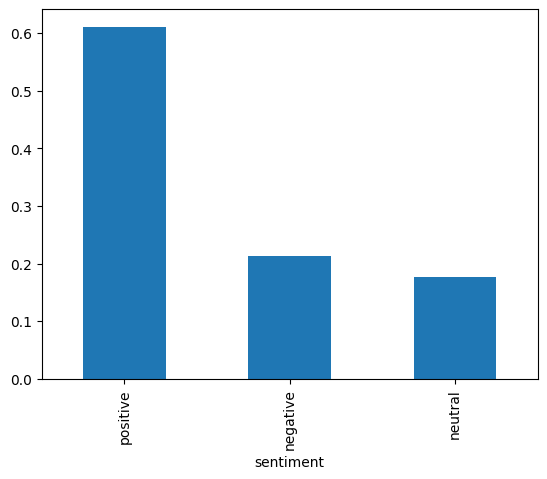

In [11]:
"""Second Bonus challenge for English language"""
df_eng['sentiment'].value_counts(normalize=True).plot.bar()

#

The bar plot displaying the proportion of recommended vs. not recommended games reveals a noticeable gap—over 20%—compared to the ratio of positive sentiments in the previous graph. 

However, combining neutral reviews with positive ones brings this proportion much closer to the recommendation ratio, indicating that most users who left a neutral review ultimately still recommended the game. 

This suggests that while these reviews may lack strong positive sentiment, they still lean toward a favorable overall experience.

<Axes: xlabel='recommended'>

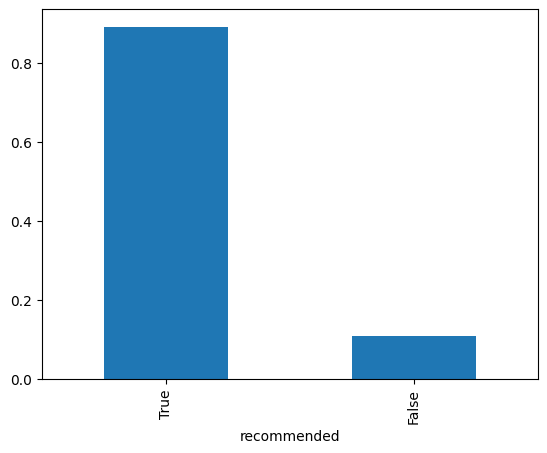

In [12]:
"""Third Bonus challenge for English language"""
df_eng['recommended'].value_counts(normalize=True).plot.bar()

#### How strongly are sentiments correlated with helpful votes?

To examine whether there is a relationship between sentiment and helpful votes, we first label positive and neutral reviews as 1, and negative reviews as 0. We then apply the point-biserial correlation, a method for determining how closely a binary feature is associated with a continuous feature, to assess the correlation between these metrics.

As shown below, the correlation is very low, at 0.00016. A p-value under 0.05 would indicate a significant correlation between the two metrics, but in this case, the p-value is above 0.6, suggesting no significant correlation.

In [ ]:
df_eng['sentiment_bin'] = df_eng.sentiment.apply(lambda x: 0 if x=='negative' else 1)

In [27]:
from scipy.stats import pointbiserialr
correlation, p_value = pointbiserialr(df_eng.sentiment_bin, df_eng.votes_helpful)
print(f"Point-Biserial Correlation: {correlation}")
print(f"P-Value: {p_value}")

Point-Biserial Correlation: 0.00016780653973910294
P-Value: 0.602444641223378


#### Working on 50000 records
Due to limitations of the Google Translate API and the time-consuming nature of translating the entire dataset, we selected only 50,000 entries. Even for this subset, translation took over four hours to convert reviews from Chinese and Russian into English.

In [ ]:
df = pd.read_csv('steam_reviews.csv', nrows=50000).drop('Unnamed: 0', axis=1)

In [24]:
import time
from tqdm import tqdm
from googletrans import Translator

translator = Translator()

# Filter for schinese language reviews and create a copy to avoid SettingWithCopyWarning
df_sch_russ = df[(df.language == 'schinese') | (df.language == 'russian')].copy()

In [26]:
# Translate reviews and handle potential rate limit issues
tqdm.pandas()
def translate_review(text):
    try:
        return translator.translate(text, dest='en').text
    except Exception as e:
        time.sleep(1)  # wait a moment before retrying
        return ''

df_sch_russ['review_en'] = df_sch_russ['review'].progress_apply(translate_review)


100%|██████████| 21448/21448 [4:44:39<00:00,  1.26it/s]  


In [30]:
df_sch_russ['review'] = df_sch_russ['review_en']
df_sch_russ.drop('review_en', axis=1, inplace=True)


In [31]:
df_sch_russ.dropna(subset = ['review'], inplace=True)
if 'Unnamed: 0' in df_sch_russ.columns:
    df_sch_russ.drop('Unnamed: 0', axis=1, inplace=True)

#### Sentiment Analysis on chinese reviews

In [ ]:
df_sch = df_sch_russ[df_sch_russ.language == 'schinese']
df_sch['sentiment'] = sentiment_analysis(df_sch)

In [33]:
df_sch.loc[df_sch.sentiment == 0.0, ['sentiment']] = 'neutral'
print(df_sch['sentiment'].value_counts())

sentiment
positive    5760
neutral     3297
negative    1744
Name: count, dtype: int64


<Axes: xlabel='sentiment'>

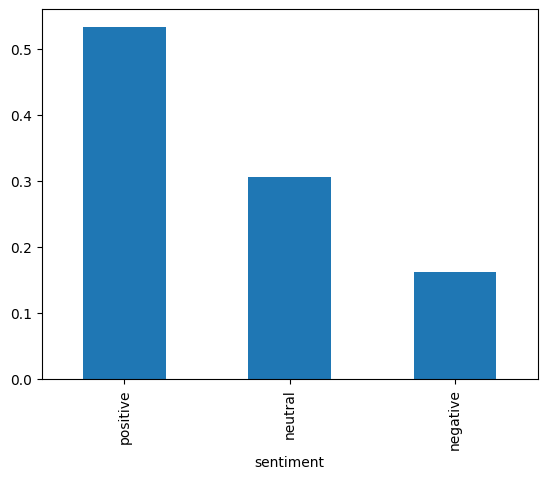

In [34]:
df_sch['sentiment'].value_counts(normalize=True).plot.bar()

<Axes: xlabel='recommended'>

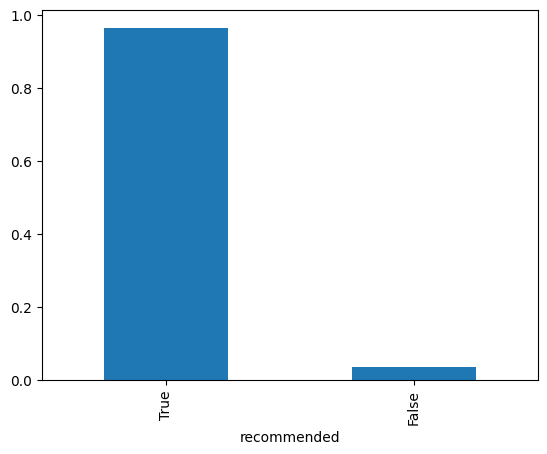

In [35]:
df_sch['recommended'].value_counts(normalize=True).plot.bar()

In [ ]:
from scipy.stats import pointbiserialr

df_sch['sentiment_bin'] = df_sch.sentiment.apply(lambda x: 0 if x=='negative' else 1)

In [39]:
correlation, p_value = pointbiserialr(df_sch.sentiment_bin, df_sch.votes_helpful)
print(f"Point-Biserial Correlation: {correlation}")
print(f"P-Value: {p_value}")

Point-Biserial Correlation: -0.012771917057275607
P-Value: 0.1844231839473014


#### Insights and Conclusions from Sentiment Analysis of Chinese Reviews
The graphs reveal that over 50% of reviews are positive, around 30% are neutral, and more than 90% of players recommend the games they've played, suggesting that many neutral reviews still lean toward recommendations. For English reviews, sentiment closely aligns with recommendations, but in Chinese reviews, a notable 10% gap persists. This difference likely stems from nuances lost in translation, as Chinese expressions may not fully convey sentiment when translated to English. This suggests that cultural and linguistic subtleties can impact sentiment analysis outcomes across languages. Another possibility is that players enjoy the game overall but are dissatisfied with a recent update, prompting them to leave a negative comment while still recommending the game as a whole.

#### Sentiment Analysis on russian reviews

In [ ]:
df_rus = df_sch_russ[df_sch_russ.language == 'russian']
df_rus['sentiment'] = sentiment_analysis(df_rus)

In [41]:
df_rus.loc[df_rus.sentiment == 0.0, ['sentiment']] = 'neutral'
print(df_rus['sentiment'].value_counts())

sentiment
positive    5187
neutral     3540
negative    1705
Name: count, dtype: int64


<Axes: xlabel='sentiment'>

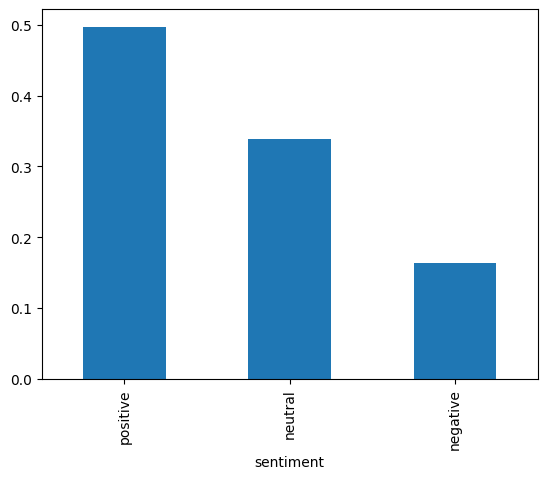

In [42]:
df_rus['sentiment'].value_counts(normalize=True).plot.bar()

<Axes: xlabel='recommended'>

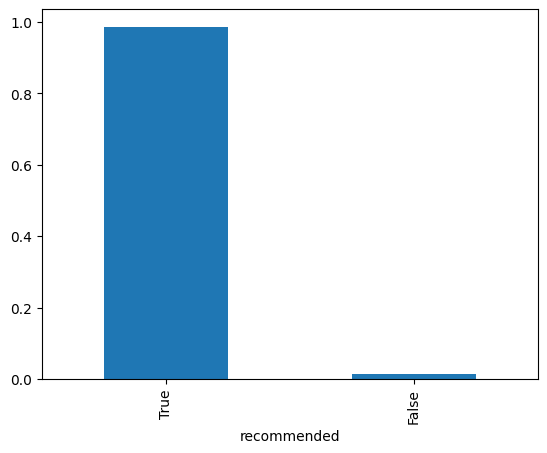

In [43]:
df_rus['recommended'].value_counts(normalize=True).plot.bar()

In [ ]:
from scipy.stats import pointbiserialr

df_rus['sentiment_bin'] = df_rus.sentiment.apply(lambda x: 0 if x=='negative' else 1)

In [45]:
correlation, p_value = pointbiserialr(df_rus.sentiment_bin, df_rus.votes_helpful)
print(f"Point-Biserial Correlation: {correlation}")
print(f"P-Value: {p_value}")

Point-Biserial Correlation: -0.02901013462500322
P-Value: 0.003043781657749243


#### Insights and Conclusions from Sentiment Analysis of Russian Reviews
The results for Russian reviews closely mirrored our findings from the analysis of Chinese reviews."

# Algorithmic Question (AQ)
You are given two positive integers, $n$ (where $1\le n \le 10^9$) and k (where $q \le k \le 100$). Your task is to express $n$ as the sum of $k$ positive integers, all having the same parity (i.e., all have the same remainder when divided by 2, meaning they are either all even or all odd).
In other words, find $a_1, a_2, ..., a_k$ each $a_i \gt 0, n = a_1 + a_2 + ... + a_k$, and all $a_i$ simultaneously are either even or odd.
If it's impossible to represent $n$ in this way, report that no such representation exists.

**Input**

In the first input line, you will receive a number t (where $1 \le t \le 100$), representing the number of test cases. The following $t$ lines will contain two values, $n$ and $k$, corresponding to each test case.

**Output**

For each test case, if it is possible to represent $n$ as the sum of $k$ positive integers, all of the same parity (either all even or all odd), print "YES" and provide the corresponding values of $a_i$ in the next line. If there are multiple valid solutions, you can print any of them. If such a representation is not possible for a given test case, print "NO".

**Examples**
---

**Input**
```
8
10 3
100 4
8 7
97 2
8 8
3 10
5 3
```
**Output**
```
YES
4 2 4
YES
55 5 5 35
NO
NO
YES
1 1 1 1 1 1 1 1
NO
YES
3 1 1
```
1. Implement a Python program to solve the problem above.
2. Please provide an analysis of your code's time complexity using Big O notation.
3. Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.
  

In [ ]:
t = int(input())

for _ in range(t):
    n, k = map(int, input().split())
    if n >= k and n % 2 == k % 2:
        print("YES")
        print(f"{n - (k-1)} {'1 ' * (k-1)}".strip())
    elif n >= 2 * k and n % 2 == 0:
        print("YES")
        print(f"{n - 2 * (k-1)} {'2 ' * (k-1)}".strip())
    else:
        print("NO")

For the first row 
```python 
t = int(input())
``` 
we have an operation in the order of $O(1)$.

Then, we entered in a for loop 
```python 
for _ in range(t):
``` 
with a time complexity in the order of $O(t)$. 

Next we map the input , 
```python 
n, k = map(int, input().split())
``` 
with an operation in the order of $O(1)$.

In the if statement 
```python 
if n >= k and n % 2 == k % 2:
``` 
we perform 2 operation , with a time comlexity of $O(2)$ .

We print the result  
```python 
print("YES")  
```
with a time complexity of $O(1)$ and we print 
```python 
print(f"{n - (k-1)} {'1 ' * (k-1)}".strip())
```
with a time complexity in the order of $O(k)$.


The elif statement 
```python 
elif n >= 2 * k and n % 2 == 0:
```
is in the order of $O(2)$   and the print 
```python 
print("YES")
print(f"{n - 2 * (k-1)} {'2 ' * (k-1)}".strip())
```
are again $O(1)$ and $O(k)$.

The last else 
```python 
else:
  print("NO")
``` 
is $O(1)$.


So the time complexity is in the order of $O(t \cdot k  )$ leaving out the costant.



#### Chat GPT Output
This is the answer given by chat gpt when we asked to give the time complexity for this algorithm using the Big O notation:

Let's go through the code line by line and determine the time complexity.

1. `t = int(input())`  
   This line takes one input, so its time complexity is $( O(1) )$.

2. `for _ in range(t):`  
   This loop runs $( t )$ times, where $( t )$ is the number of test cases.

3. Inside the loop:
   - `n, k = map(int, input().split())`  
     Each time through the loop, the code reads a line and splits it into two integers. This operation is $( O(1) )$ in terms of time complexity.

   - The next part consists of three conditional statements:
     - `if n >= k and n % 2 == k % 2:`  
       This condition checks if $( n \geq k )$ and whether $( n )$ and $( k )$ have the same parity. Both checks are $( O(1) )$.
       - If the condition is true, the code prints `"YES"` and a formatted string of $( k )$ numbers, with one large number and $( k-1 )$ ones. Constructing and printing this string takes $( O(k) )$.
     
     - `elif n >= 2 * k and n % 2 == 0:`  
       If the first condition is false, this one checks if $( n \geq 2k )$ and if $( n )$ is even. Both are $( O(1) )$.
       - If true, it prints `"YES"` and a formatted string with one large number and $( k-1 )$ twos. Again, constructing and printing the string takes $( O(k) )$.

     - `else:`  
       If neither of the above conditions are met, it simply prints `"NO"`, which is $( O(1) )$.

**Overall Complexity**
The loop runs $( t )$ times, and each iteration has an $( O(k) )$ operation due to printing, with other parts being $( O(1) )$. Thus, the complexity of this algorithm is:
$[ O(t \times k) ]$

Our explanation and the answer provided by ChatGPT are very similar and both lead to the same time complexity which is $O(t \times k)$.
However, there is a difference in the analysis:

- in the if and elif statement we put time complexity equal to $2$ because we have two different operations. For the LLm tool, this is not necessary because these operations are still $O(1)$ in terms of complexity. This because in Big O notation, even if we perform two operations, if these are between two constant the complexity remains $O(1)$.

